# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC

# Loading Data

In [2]:
oj = pd.read_csv("../data/OJ.csv")
oj.dropna(axis=0)
oj["Store7"] = [1 if item == "Yes" else 0 for item in oj["Store7"]]
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


In [3]:
X = oj.drop("Purchase", axis=1)
y = oj["Purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=0)

# Decision Tree Classifier

In [4]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
[clf.score(X_train, y_train), clf.score(X_test, y_test)]

[0.99125, 0.7296296296296296]

In [5]:
print(export_text(clf))

|--- feature_8 <= 0.51
|   |--- feature_8 <= 0.28
|   |   |--- feature_8 <= 0.06
|   |   |   |--- feature_1 <= 1.50
|   |   |   |   |--- feature_15 <= 0.15
|   |   |   |   |   |--- class: CH
|   |   |   |   |--- feature_15 >  0.15
|   |   |   |   |   |--- class: MM
|   |   |   |--- feature_1 >  1.50
|   |   |   |   |--- feature_0 <= 268.50
|   |   |   |   |   |--- class: MM
|   |   |   |   |--- feature_0 >  268.50
|   |   |   |   |   |--- feature_8 <= 0.00
|   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |--- feature_8 >  0.00
|   |   |   |   |   |   |--- class: CH
|   |   |--- feature_8 >  0.06
|   |   |   |--- feature_0 <= 273.50
|   |   |   |   |--- feature_10 <= 1.94
|   |   |   |   |   |--- feature_0 <= 263.50
|   |   |   |   |   |   |--- feature_16 <= 1.50
|   |   |   |   |   |   |   |--- feature_0 <= 228.00
|   |   |   |   |   |   |   |   |--- class: CH
|   |   |   |   |   |   |   |--- feature_0 >  228.00
|   |   |   |   |   |   |   |   |--- feature_8 <= 0.13
|   |   |

In [6]:
y_predict = clf.predict(X_test)
confusion_matrix(y_true=y_test, y_pred=y_predict, labels=["CH", "MM"])

array([[115,  38],
       [ 35,  82]], dtype=int64)

# Decision Tree Classifier with Cost-Complexity Pruning (CCP)

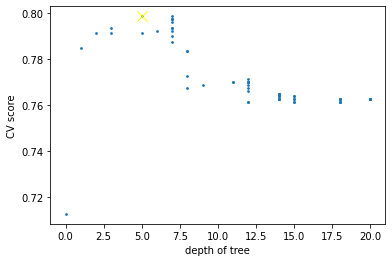

In [7]:
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas
depths = []
scores = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha, random_state=0)
    clf.fit(X_train, y_train)
    depths.append(clf.get_depth())
    scores.append(np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

plt.scatter(depths, scores, s=3)
plt.plot(depths[np.argmax(scores)], max(scores), marker="x", ms=10, c="yellow")
plt.xlabel("depth of tree")
plt.ylabel("CV score")
plt.show()

In [8]:
best_depth = depths[np.argmax(scores)]
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=0)
clf.fit(X_train, y_train)
[clf.score(X_train, y_train), clf.score(X_test, y_test)]

[0.8625, 0.7703703703703704]

# Ensemble Methods

In [9]:
# Gradient Boosting
boosting = GradientBoostingClassifier(warm_start=True, random_state=0)
boosting.fit(X_train, y_train)
[boosting.score(X_train, y_train), boosting.score(X_test, y_test)]

[0.89375, 0.7962962962962963]

In [10]:
# Bagging
bagging = BaggingClassifier(base_estimator=clf, warm_start=True, random_state=0)
bagging.fit(X_train, y_train)
[bagging.score(X_train, y_train), bagging.score(X_test, y_test)]

[0.875, 0.8185185185185185]

In [11]:
# Random Forest
forest = RandomForestClassifier(warm_start=True, random_state=0)
forest.fit(X_train, y_train)
[forest.score(X_train, y_train), forest.score(X_test, y_test)]

[0.99125, 0.7703703703703704]

# Support Vector Machines (SVMs)

In [12]:
# Linear kernel SVC
svc = SVC(random_state=0)
svc.fit(X_train, y_train)

grid = {"C": np.linspace(1, 30, 60)}
tuned_svc = GridSearchCV(estimator=svc, param_grid=grid, cv=5)
tuned_svc.fit(X_train, y_train)
[tuned_svc.score(X_train, y_train), tuned_svc.score(X_test, y_test)]

[0.625, 0.5666666666666667]

In [13]:
# Quadratic kernel SVC
svc = SVC(random_state=0, kernel="poly", degree=2)
svc.fit(X_train, y_train)

grid = {"C": np.linspace(1, 30, 60)}
tuned_svc = GridSearchCV(estimator=svc, param_grid=grid, cv=5)
tuned_svc.fit(X_train, y_train)
[tuned_svc.score(X_train, y_train), tuned_svc.score(X_test, y_test)]

[0.625, 0.5666666666666667]

In [14]:
# Radial basis function kernel SVC
svc = SVC(random_state=0, kernel="rbf")
svc.fit(X_train, y_train)

grid = {"C": np.linspace(1, 30, 60), "kernel": ["rbf"], "random_state": [0]}
tuned_svc = GridSearchCV(estimator=svc, param_grid=grid, cv=5)
tuned_svc.fit(X_train, y_train)
[tuned_svc.score(X_train, y_train), tuned_svc.score(X_test, y_test)]

[0.625, 0.5666666666666667]